<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 3a. Cross-Modal Projection

Earlier in this course, we covered a variety of different matrix algebra operations to develop multimodal model architecture. In this lab, we will be exploring a relatively advanced but powerful technique: cross-modal projection. While this technique is commonly used to project image embeddings into a text embedding space, it is not limited to this data type. This time, we will try an opposite approach. Can we project text embeddings into the image embedding space?

#### Learning Objectives

The goals of this notebook are to:
* Investigate the cross-model projector architecture
* Train a cross-model projector
* Integrate a cross-model projector into an existing model

Let's load some libraries to get started.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import pandas as pd
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 3.1 Setup
### 3.1.1 The Dataset

To project one mode onto another, it would be useful to have a model as base. Let's build a convolutional neural network to classify images while we explore our dataset. We can use [VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html), a pre-trained image classifier, as a base.

In [2]:
# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)
vgg_model.requires_grad_(False) # Freeze model during training

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 322MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG16 comes with a set of [torchvision transforms](https://pytorch.org/vision/0.9/transforms.html) we can use to convert images into the shape and format VGG16 can ingest.

In [3]:
pre_trans = weights.transforms()
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Before applying these transformations to all of our data, let's test it on one example. We have a few different flower photos located in the `data/flower_photos/` folder. These photos were taken at the [Elizabeth F. Gamble Garden](https://www.gamblegarden.org/visit-us/overview/) in Palo Alto. Please visit if you get the chance!

<center><img src="data/flower_photos/PXL_20250104_202132415.jpg" width="25%"/></center>

In [4]:
img_path = "data/flower_photos/PXL_20250104_202132415.jpg"
image = Image.open(img_path)

The following code will apply the transforms and print out the result. Because the image is being normalized, the result will look a bit abstract.

Original image shape:  (2560, 1920, 3)
Processed image shape:  torch.Size([3, 224, 224])


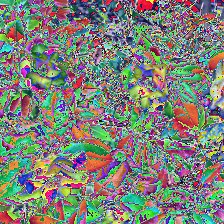

In [5]:
print('Original image shape: ', mpimg.imread(img_path).shape)
processed_image = tv_io.read_image(img_path).to(device)
processed_image = pre_trans(image)  # weights.transforms()
print("Processed image shape: ", processed_image.shape)
pil_image = torchvision.transforms.functional.to_pil_image(processed_image)
pil_image

Speaking of image transforms, let's define a little bit of data augmentation. We'll randomly [crop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html) and [flip](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) the image to add more variety to our dataset.

In [6]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip()
])

We can scale these steps for all of our flower photos. Let's look at the data:

In [7]:
DATA_DIR = 'data/'
df = pd.read_csv(DATA_DIR + 'flower_photos.csv')
df

,Filename,Flower Type,Class ID,Description
0,PXL_20250104_200943753.jpg,Kniphofia Uvaria,0,"The flower in the image is a type of aloe, cha..."
1,PXL_20250104_200946941.jpg,Kniphofia Uvaria,0,The flower in the image is a vibrant orange an...
2,PXL_20250104_200949642.jpg,Kniphofia Uvaria,0,The flower in the image is a vibrant orange an...
3,PXL_20250104_200952892.jpg,Kniphofia Uvaria,0,The flower in the image is a vibrant orange co...
4,PXL_20250104_200955033.jpg,Kniphofia Uvaria,0,The flower in the image is a type of Kniphofia...
5,PXL_20250104_200958637.jpg,Kniphofia Uvaria,0,The flower in the image is a type of Kniphofia...
6,PXL_20250104_201018875.jpg,Kniphofia Uvaria,0,The image captures a vibrant scene from nature...
7,PXL_20250104_201024513.jpg,Kniphofia Uvaria,0,The image captures a close-up view of a vibran...
8,PXL_20250104_201025684.jpg,Kniphofia Uvaria,0,The flower in the image is a vibrant orange an...
9,PXL_20250104_201030008.jpg,Kniphofia Uvaria,0,"The flower in the image is a type of aloe, cha..."


There are `3` different kinds of flowers in our dataset:
* [Kniphofia Uvaria](https://en.wikipedia.org/wiki/Kniphofia_uvaria)
* [Salvia Splendens](https://en.wikipedia.org/wiki/Salvia_splendens)
* [Tagetes Patula](https://en.wikipedia.org/wiki/Tagetes_patula)

This dataset is not very large, and that's ok. Because we're using a pre-trained model, the model will have enough prior context in order to learn from these images. We will also purposely overfit this data to verify to architecture can learn on this kind of data. Once we see that the model is learning, we can expand our dataset and create validation data.

In [8]:
patch_length = 150
patches = 3

class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.descriptions = []
        self.labels = []
        
        for idx in range(len(df)):
            row = df.loc[idx]
            img = Image.open(DATA_DIR + "flower_photos/" + row["Filename"])
            self.imgs.append(pre_trans(img).to(device))
            text_patches = [row["Description"][t*patch_length:(t+1)*patch_length] for t in range(patches)]
            self.descriptions.append(text_patches)
            label = torch.tensor(row["Class ID"]).to(device)
            self.labels.append(label)


    def __getitem__(self, idx):
        img = self.imgs[idx]
        description = self.descriptions[idx]
        label = self.labels[idx]
        return img, description, label

    def __len__(self):
        return len(self.imgs)

Now that we've defined our dataset, let's initialize it.

In [9]:
BATCH_SIZE = 32
train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_N = len(dataloader.dataset)

### 3.1.2 The Image Classification Model

Time to make our image classification model. We'll use most of the VGG16 model, but we'll remove the last few layers and add our own instead. The vector output of the VGG16 portion of the model will become our `embedder` before being fed to the rest of the model.`

To make it easier for other developers to use this embedding, we will define a `get_img_embs` function.

In [10]:
N_CLASSES = 3

class FlowerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedder = nn.Sequential(
            vgg_model.features,
            vgg_model.avgpool,
            nn.Flatten(),
            vgg_model.classifier[0:3]
        )
        self.classifier = nn.Sequential(
            nn.Linear(4096, 500),
            nn.ReLU(),
            nn.Linear(500, N_CLASSES)
        )

    def get_img_embs(self, imgs):
        return self.embedder(imgs)
    
    def forward(self, imgs=None, img_embs=None):
        assert (imgs is not None or img_embs is not None), "No images or embeddings given."
        if imgs is not None:
            img_embs = self.get_img_embs(imgs)
        return self.classifier(img_embs)

In [11]:
flower_classifier = FlowerClassifier().to(device)

Almost done. Let's define out loss function. Since we're classifying these photos into multiple categories, we should use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function.

In [12]:
def get_classifier_loss(model, batch):
    imgs, _, labels = batch
    pred_labels = model(imgs=random_trans(imgs))
    accuracy = get_batch_accuracy(pred_labels, labels, train_N)
    return nn.CrossEntropyLoss()(pred_labels, labels), accuracy

In `get_classifier_loss`, there is a yet-to-be-defined `get_batch_accuracy` function. Let's define that now. It'll be easier to tell how well the model is performing with the accuracy function instead of the loss function.

In [13]:
def get_batch_accuracy(pred, label, N):
    y = pred.argmax(dim=-1)
    correct = y.eq(label).sum().item()
    return correct / N

Finally, let's define the function to train the model. We'll be reusing this function to train multiple models, so let's make it flexible by adding the loss function (`loss_fn`) as a parameter.

In [14]:
def train_model(model, loss_fn, epochs=20, print_accuracy=False):
    lrate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

    model.train()
    for epoch in range(epochs):
        accuracy = 0
        batch_accuracy = 0
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            loss, batch_accuracy = loss_fn(model, batch)
            accuracy += batch_accuracy
            loss.backward()
            optimizer.step()

        out_string = f"Epoch {epoch:3d} | Loss: {loss.item():2.4f}"
        if print_accuracy:
            out_string += f" | Accuracy {accuracy:2.4f}"
        print(out_string)
    
    model.eval()

Moment of truth! Let's see how well this classifier learns.

In [15]:
train_model(flower_classifier, get_classifier_loss, epochs=10, print_accuracy=True)

Epoch   0 | Loss: 1.0388 | Accuracy 0.4242
Epoch   1 | Loss: 0.1059 | Accuracy 0.9394
Epoch   2 | Loss: 2.1138 | Accuracy 0.7576
Epoch   3 | Loss: 0.0000 | Accuracy 0.9697
Epoch   4 | Loss: 0.1271 | Accuracy 0.9394
Epoch   5 | Loss: 1.5820 | Accuracy 0.8485
Epoch   6 | Loss: 0.0000 | Accuracy 0.9697
Epoch   7 | Loss: 0.0000 | Accuracy 0.9697
Epoch   8 | Loss: 0.0000 | Accuracy 0.9697
Epoch   9 | Loss: 0.0000 | Accuracy 0.9697


Due to the randomness behind model training, different runs can have different results. When we ran it, we got an accuracy of about `0.9697`, which is about `96.97%`. Not bad! This will be our benchmark going forward. Let's see if we can change the modality of this model while maintaining this accuracy.

## 3.2 Cross-Modal Projection

Now that we have a base model, let's see how we can change its modality. If a model that projects image embeddings onto text embeddings is called a Vision Language Model (VLM), let's call a model that projects text embeddings onto image embeddings a Language Vision Model (LVM).

To start, let's find a way to get text embeddings. Since it is already designed to correlate text and images, let's use [CLIP](https://github.com/openai/CLIP).

In [16]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]


Before we create a model with CLIP, let's get some practice. First, we'll create a list of strings:

In [17]:
text_list = [
    "A Kniphofia Uvaria flower",
    "A Salvia Splendens flower",
    "A Tagetes Patula flower"
]

Then, we'll run it through CLIP to get an encoding. In this case, we'll use our encoding as our embedding.

In [18]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.3291,  0.1130,  0.0986,  ...,  0.2795,  0.0989, -0.1392],
        [-0.2527,  0.1716,  0.3647,  ...,  0.3652,  0.1472,  0.1576],
        [-0.1278,  0.2795, -0.1249,  ...,  0.2598,  0.3091, -0.2627]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

To project CLIP embeddings onto VGG16 embeddings, we should note both the CLIP embedding size and the VGG16 embedding size.

In [19]:
clip_emb_size = clip_text_encodings[0].shape
clip_emb_size

torch.Size([512])

CLIP has a maximum token length of 77, but our text descriptions of our flowers are much larger than that. In order to add more information, we'll break our text descriptions down into `patches`. Not only does it allow us to analyze a larger description, but we can also spatially break down the reasoning of our text.

Because of this patching, we will run CLIP multiple times per row of description in our dataset. Let's make a function (`get_clip_encodings`) to run through the list of patches. We can use python [list comprehension](https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions) to make the operation independent of the patch size. Then, we can take our list of encodings and concatenate them together.

In [20]:
def get_clip_encodings(texts):
    text_tokens = [clip.tokenize(t).to(device) for t in texts]
    clip_text_encodings = [clip_model.encode_text(t).float() for t in text_tokens]
    return torch.cat(clip_text_encodings, dim=1)

There are multiple ways we could deduce the VGG16 embedding size. We could look at the model summary. Another way is to feed an image through our `get_img_embs` and check the size of the output. We can batch our `processed_image` with [unsqueeze](https://pytorch.org/docs/main/generated/torch.unsqueeze.html) to test it out.

In [21]:
test_image = torch.unsqueeze(processed_image, 0).to(device)
imb_embs = flower_classifier.get_img_embs(test_image)
vgg_shape = imb_embs[0].shape
vgg_shape

torch.Size([4096])

Now that we know the size we're converting from and the size we're converting to, we can make our modal `projector`. We can use any neural network operations we want as long as our input dimensions and our output dimensions reflect this conversion. It may be surprising to see we only need a few linear layers. Even state-of-the-art Vision Language Models like LLaVA only use a few linear layers in [their projector](https://github.com/huggingface/transformers/blob/v4.49.0/src/transformers/models/llava/modeling_llava.py#L88).

In [22]:
projector = nn.Sequential(
    nn.Linear(clip_emb_size[0]*patches, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, vgg_shape[0])
).to(device)

We will use our image-description pairs to train the projector. The text description will be fed through CLIP and the projector while the corresponding image will be fed through the `flower_classifier`'s `get_img_embs` function.

Since we're trying to minimize the distance between our predicted image embeddings and the true image embeddings, our loss function will change. Even though we're working in an abstract image and text space, the math is not much different than our robotics position predictor from earlier in the course. Like in those previous labs, we will use the [Mean Squared Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) loss function.

In [23]:
def get_projector_loss(model, batch):
    imgs, texts, _ = batch
    imb_embs = flower_classifier.get_img_embs(imgs)

    text_encodings = get_clip_encodings(texts)
    pred_img_embs = model(text_encodings).to(device)
    return nn.MSELoss()(pred_img_embs, imb_embs), 0

Time to train the model! Let's see how well we can project these text embeddings into image embeddings.

In [24]:
train_model(projector, get_projector_loss, epochs=50)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   0 | Loss: 0.7759
Epoch   1 | Loss: 0.7716
Epoch   2 | Loss: 0.6856
Epoch   3 | Loss: 0.5950
Epoch   4 | Loss: 0.6147
Epoch   5 | Loss: 0.5129
Epoch   6 | Loss: 0.4856
Epoch   7 | Loss: 0.4709
Epoch   8 | Loss: 0.4645
Epoch   9 | Loss: 0.4541
Epoch  10 | Loss: 0.4232
Epoch  11 | Loss: 0.4098
Epoch  12 | Loss: 0.3850
Epoch  13 | Loss: 0.3622
Epoch  14 | Loss: 0.3567
Epoch  15 | Loss: 0.3386
Epoch  16 | Loss: 0.3262
Epoch  17 | Loss: 0.3212
Epoch  18 | Loss: 0.3097
Epoch  19 | Loss: 0.3010
Epoch  20 | Loss: 0.2936
Epoch  21 | Loss: 0.2882
Epoch  22 | Loss: 0.2848
Epoch  23 | Loss: 0.2749
Epoch  24 | Loss: 0.2717
Epoch  25 | Loss: 0.2654
Epoch  26 | Loss: 0.2512
Epoch  27 | Loss: 0.2369
Epoch  28 | Loss: 0.2449
Epoch  29 | Loss: 0.2391
Epoch  30 | Loss: 0.2335
Epoch  31 | Loss: 0.2292
Epoch  32 | Loss: 0.2143
Epoch  33 | Loss: 0.2143
Epoch  34 | Loss: 0.2088
Epoch  35 | Loss: 0.1963
Epoch  36 | Loss: 0.1907
Epoch  37 | Loss: 0.1927
Epoch  38 | Loss: 0.1868
Epoch  39 | Loss: 0.1814


## 3.3 A Language Vision Model

It looks like a projector model was able to learn something, but it is difficult to say how accurate its predictions are. Let's connect it to our `flower_classifier` in order to test how much it learned.`

We can create a new model `MyLVM` to feed the output of our projector as image embeddings in our classifier.

In [25]:
class MyLVM(nn.Module):
    def __init__(self):
        super().__init__()
        self.projector = projector
        self.flower_classifier = flower_classifier
    
    def forward(self, texts):
        text_encodings = get_clip_encodings(texts)
        proj_img_embs = self.projector(text_encodings).to(device)
        return self.flower_classifier(img_embs=proj_img_embs)

In [26]:
my_lvm = MyLVM()

Now that we're back to using a classifier model, let's update our loss function. This time, we'll take our text descriptions and feed it into our model to see how well it can identify the correct flower.

In [27]:
def get_LVM_loss(model, batch):
    _, texts, labels = batch
    pred_labels = model(texts)
    accuracy = get_batch_accuracy(pred_labels, labels, train_N)
    return nn.CrossEntropyLoss()(pred_labels, labels), accuracy

Before we do anymore training, let's see how the model does as is. We'll one through one epoch of the dataset to calculate our total accuracy.

In [28]:
my_lvm.eval()
accuracy = 0
batch_accuracy = 0
for step, batch in enumerate(dataloader):
    loss, batch_accuracy = get_LVM_loss(my_lvm, batch)
    accuracy += batch_accuracy

out_string = f"Loss: {loss.item():2.4f} | Accuracy {accuracy:2.4f}"
print(out_string) 

Loss: 0.0000 | Accuracy 0.9697


Not bad again! Even though the loss of the projector isn't perfect, it does a good enough job for the `flower_classifier` to understand what is being passed to it.

In the paper [Vision Instruction Tuning](https://arxiv.org/abs/2304.08485), it describes a two step approach to training a cross-modal projection model. The first-step we already did: training a projector on embedding pairs. The second step is to fine-tune the entire VLM. Let's replicate the second step for our LVM. This trains the whole pipeline from the inputed text to the output flower prediction.

In [29]:
train_model(my_lvm, get_LVM_loss, epochs=30, print_accuracy=True)

Epoch   0 | Loss: 0.0000 | Accuracy 0.9697
Epoch   1 | Loss: 0.0000 | Accuracy 0.9697
Epoch   2 | Loss: 0.0000 | Accuracy 0.9697
Epoch   3 | Loss: 0.0000 | Accuracy 0.9697
Epoch   4 | Loss: 0.0000 | Accuracy 0.9697
Epoch   5 | Loss: 0.0000 | Accuracy 0.9697
Epoch   6 | Loss: 0.0000 | Accuracy 0.9697
Epoch   7 | Loss: 0.0000 | Accuracy 0.9697
Epoch   8 | Loss: 0.0000 | Accuracy 0.9697
Epoch   9 | Loss: 0.0000 | Accuracy 0.9697
Epoch  10 | Loss: 0.0000 | Accuracy 0.9697
Epoch  11 | Loss: 0.0000 | Accuracy 0.9697
Epoch  12 | Loss: 0.0000 | Accuracy 0.9697
Epoch  13 | Loss: 0.0000 | Accuracy 0.9697
Epoch  14 | Loss: 0.0000 | Accuracy 0.9697
Epoch  15 | Loss: 0.0000 | Accuracy 0.9697
Epoch  16 | Loss: 0.0000 | Accuracy 0.9697
Epoch  17 | Loss: 0.0000 | Accuracy 0.9697
Epoch  18 | Loss: 0.0000 | Accuracy 0.9697
Epoch  19 | Loss: 0.0000 | Accuracy 0.9697
Epoch  20 | Loss: 0.0000 | Accuracy 0.9697
Epoch  21 | Loss: 0.0000 | Accuracy 0.9697
Epoch  22 | Loss: 0.0000 | Accuracy 0.9697
Epoch  23 |

## Next

Congrats on finishing the lab! This concludes the more mathematical theory section of the course. In the next few labs, we will be reviewing how multi-modal models are used in practice. We're going to need a lot of resources to run these models. Please restart the kernel before continuing.

In [30]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>